<font color="FF3B3B"><h1 align="left">Proyecto de aprendizaje profundo</h1></font>
<font color="#6E6E6E"><h2 align="left">Modelo de red neuronal simple</h2></font>

##### David Alejandro Pedroza De Jesús
##### Joel Ezequiel Vicente Alonso

Cargamos las librerias para la realización del proyecto

In [23]:
import sys
sys.path.append("../")
from modelos.RNNSimple import ModeloSimpleCLS
import numpy as np
import pandas as pd
import cv2
import kagglehub
import os
from shutil import move
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Descarga, carga y limpieza de datos

Aquí como siempre descargamos los datos y lo movemos a la carpeta de trabajo.

In [3]:
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
move(path,os.getcwd())

100%|██████████| 385M/385M [00:02<00:00, 195MB/s]

Extracting files...


'/content/2'

In [4]:
os.rename("2", "cards-image-datasetclassification")

In [5]:
datos = pd.read_csv(r"cards-image-datasetclassification/cards.csv")
datos.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


Quitamos las rutas como hemos hecho siempre.

In [6]:
rutas_adaptadas = ["cards-image-datasetclassification/" +  ruta for ruta in datos["filepaths"]]
im_buenas = []
im_malas = []
for ru in rutas_adaptadas:
    im = cv2.imread(ru)
    if  im is not None:
        im_buenas.append(ru)
    else:
        im_malas.append(ru)
print(f"Lecturas correctas: {len(im_buenas)}")
print(f"Lecturas incorrectas: {len(im_malas)}")

df_limpio = datos[np.array(rutas_adaptadas) != np.array(im_malas)]
df_limpio["rutas_adap"] = im_buenas

Lecturas correctas: 8154
Lecturas incorrectas: 1


/tmp/ipython-input-267/4150467203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio["rutas_adap"] = im_buenas


Ahora creamos una función que normalice y cargue las imagenes, para ello crearemos una función que haga esa función.

In [7]:
def CargarImg(path, size):
    img = cv2.imread(path)
    img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_RGB, size)
    return np.array(img_resize / 255.)

Cargamos los datos necesarios para el entrenamiento.

In [8]:

rutas_train = df_limpio[df_limpio["data set"] == "train"].rutas_adap
rutas_test = df_limpio[df_limpio["data set"] == "test"].rutas_adap
rutas_val = df_limpio[df_limpio["data set"] == "valid"].rutas_adap

X_train = np.array([CargarImg(path, (128, 128)) for path in rutas_train])
X_test = np.array([CargarImg(path, (128, 128)) for path in rutas_test])
X_val = np.array([CargarImg(path, (128, 128)) for path in rutas_val])

y_train = df_limpio[df_limpio["data set"] == "train"]["labels"]
y_test = df_limpio[df_limpio["data set"] == "test"]["labels"]
y_val = df_limpio[df_limpio["data set"] == "valid"]["labels"]

Por ultimo codificamos las salidas con laber encoder.

In [9]:

encoder = LabelEncoder()

y_train_num = encoder.fit_transform(y_train)
y_val_num   = encoder.transform(y_val)
y_test_num  = encoder.transform(y_test)

# Entrenamiento

Ahora entraremos el modelo simple para ver que resultados tenemos.Primero cargaremos la arquitectura del modelo usando nuestra función de `modelos/RNNSimple.py`.

In [10]:
model = ModeloSimpleCLS((128, 128, 3), y_train.unique().shape[0])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 508032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 53)             │    26,925,749 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,926,645 (102.72 MB)

 Trainable params: 26,926,645 (102.72 MB)

 Non-trainable params: 0 (0.00 B)

Ahora entrenamos nuestro modelo.

In [11]:
hist = model.fit(X_train, y_train_num,validation_data=(X_val, y_val_num), epochs=50)

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - categorical_accuracy: 0.0245 - loss: 15.5311 - val_categorical_accuracy: 0.0491 - val_loss: 1.6443
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - categorical_accuracy: 0.0177 - loss: 0.7287 - val_categorical_accuracy: 0.0264 - val_loss: 1.9112
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.0213 - loss: 0.2475 - val_categorical_accuracy: 0.0340 - val_loss: 1.7155
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.0178 - loss: 0.1300 - val_categorical_accuracy: 0.0151 - val_loss: 1.9369
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.0205 - loss: 0.0577 - val_categorical_accuracy: 0.0226 - val_loss: 2.0098
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - categorical_accuracy: 0.0167 - loss: 0.0755 - val_categorical_accuracy: 0.0226 - val_loss: 2.4572
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - categorical_accuracy: 0.0

# Evaluación del modelo

En este apartado se encuentra lo pedio en la tarea, además de algunas metricas adicionales.Empezaremos midiendo y comparando el de entrenamiento y validación.En el gráfico vemos que el error en entramiento baja, pero en validación esto no ocurre lo que indica sobre ajuste.

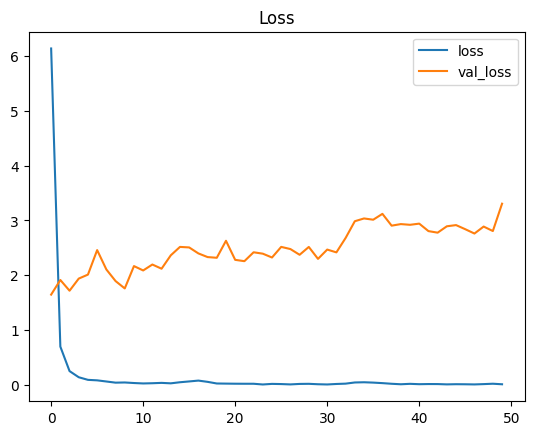

In [18]:
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.title("Loss")
plt.legend()
plt.show()

El accuracy por otra parte no es estable en absoluto, en train el accuracy se mantiene estable pero no se puede decir lo mismo del conjunto de validación.Esto puede ser un indicativo de lo que ya sabiamos, el modelo esta practicamente adivinando la clase.

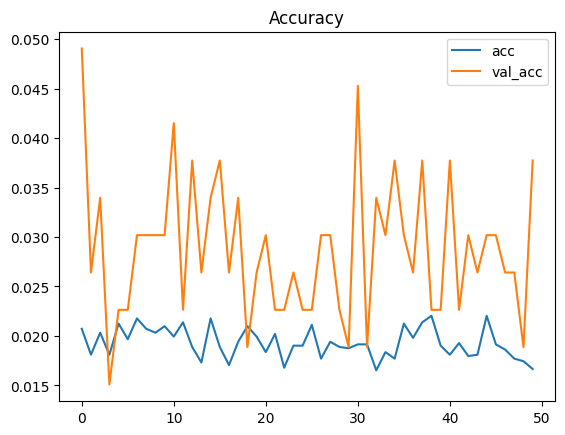

In [19]:
acc = hist.history["categorical_accuracy"]
val_acc = hist.history["val_categorical_accuracy"]

plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.title("Accuracy")
plt.legend()
plt.show()

Los resutados numericos y la evalucación en test no son muy alentadores debido a que tenemos un error muy grande y accuracy muy baja, esto esta muy lejos de ser idal.La unica excepción es el error de entramiento que es razonablemente bajo pero su accuracy no ayuda mucho.

In [21]:
train_loss, train_acc = model.evaluate(X_train, y_train_num, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val_num, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test_num, verbose=0)

print("TRAIN:")
print("Loss:", round(train_loss,3))
print("Accuracy:", round(train_acc,3))

print("\nVALIDATION:")
print("Loss:", round(val_loss,3))
print("Accuracy:", round(val_acc,3))

print("\nTEST:")
print("Loss:", round(test_loss,3))
print("Accuracy:", round(test_acc,3))

TRAIN:
Loss: 0.016
Accuracy: 0.013

VALIDATION:
Loss: 3.305
Accuracy: 0.038

TEST:
Loss: 3.393
Accuracy: 0.026


## Matriz de confución.

Vemos que a la hora de predecir el modelo no es muy bueno.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


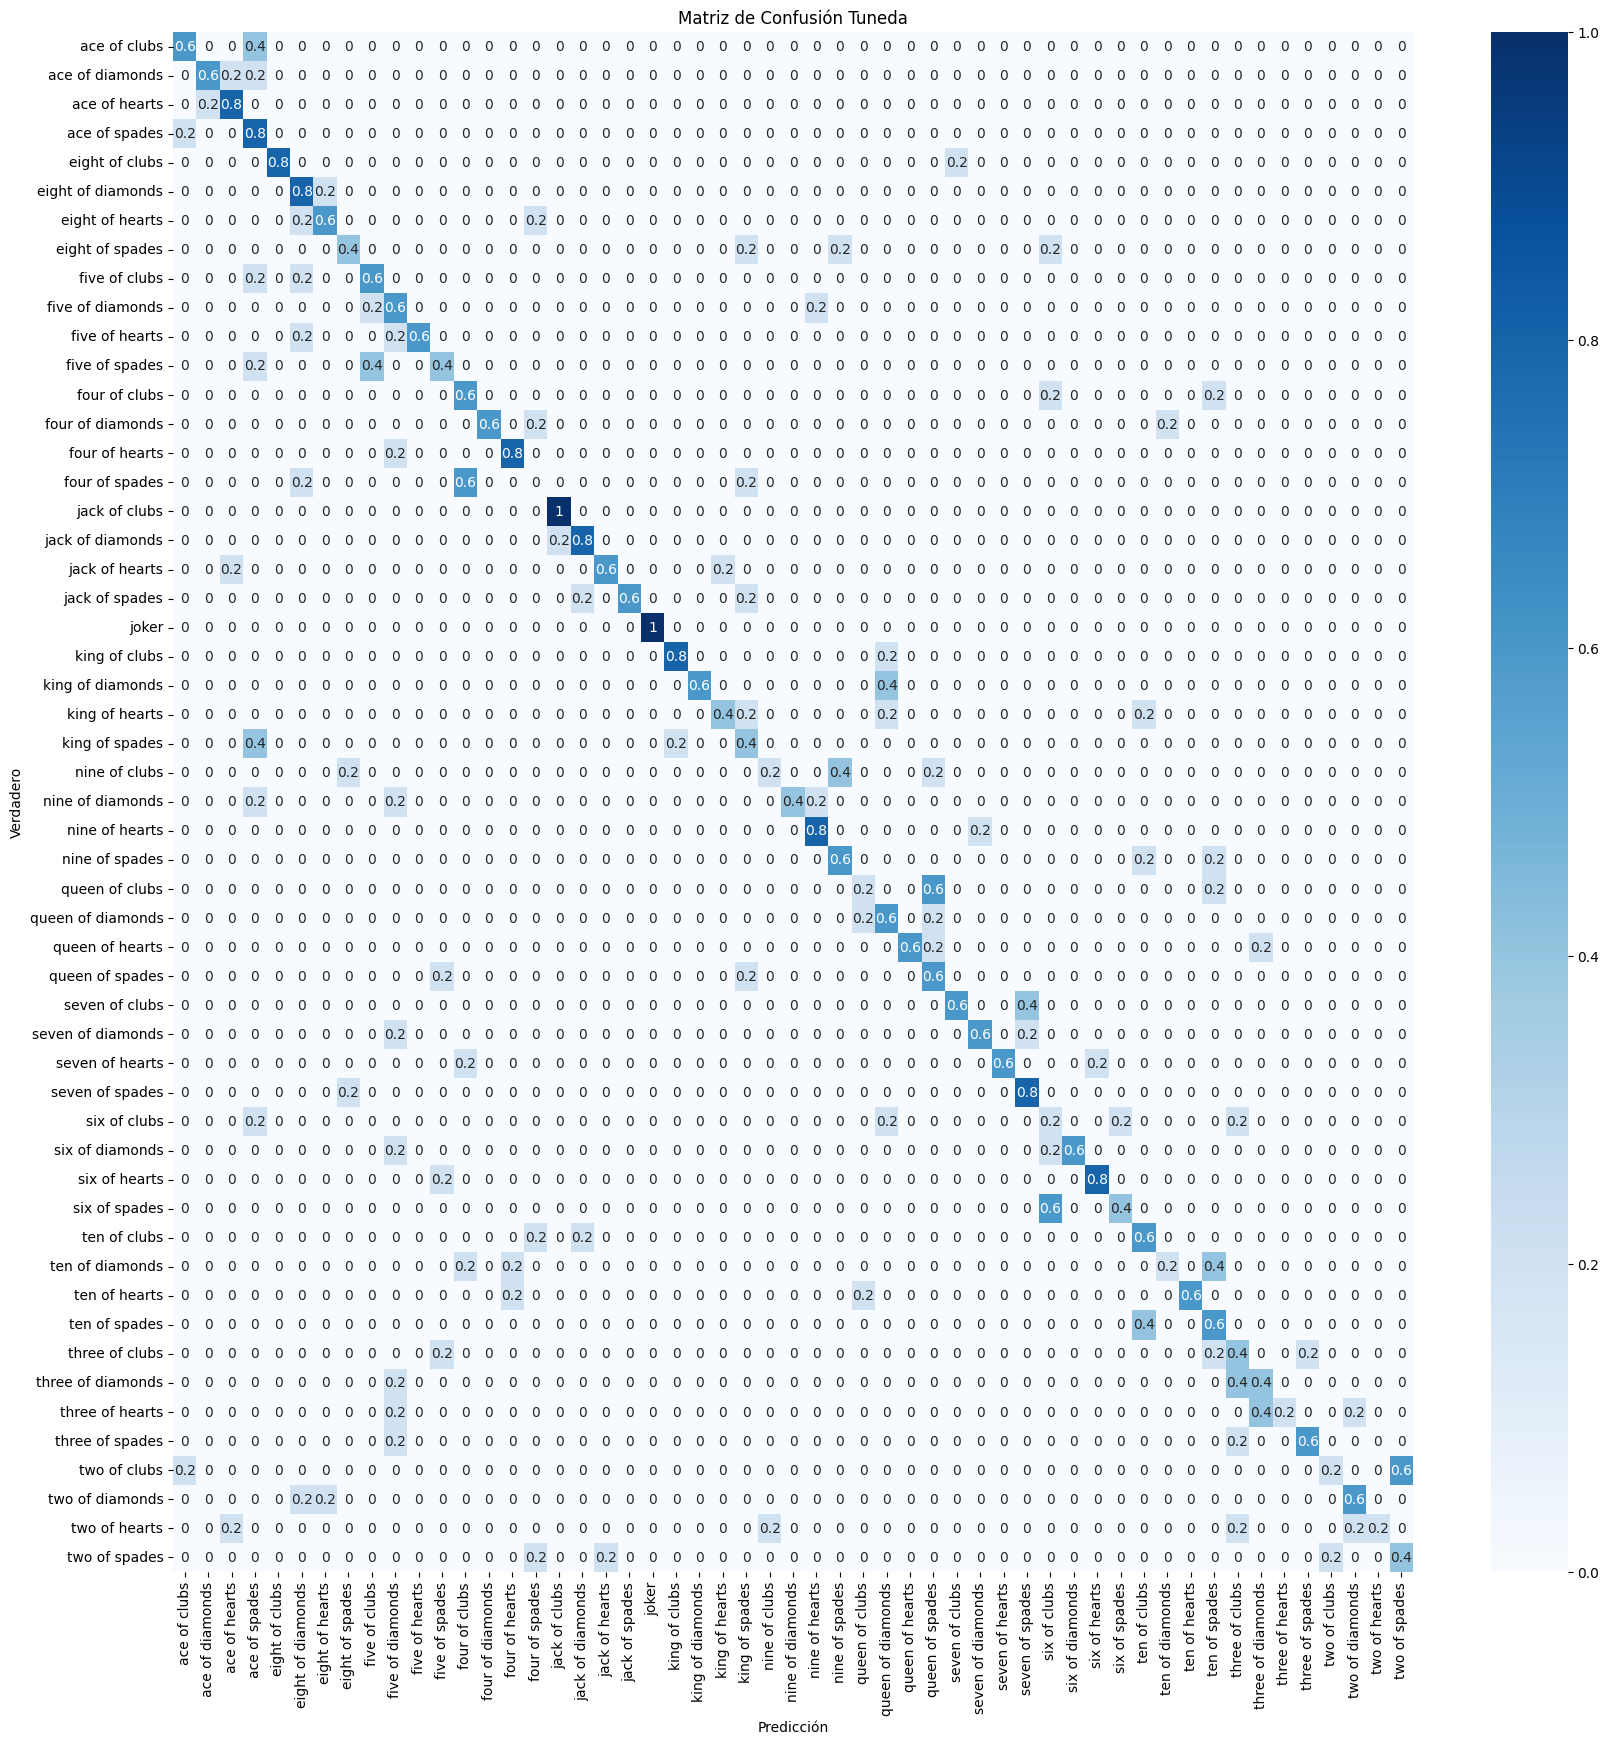

In [25]:

class_names = encoder.classes_


cm = confusion_matrix(y_test_num, np.argmax(model.predict(X_test), axis=1), normalize="true")


plt.figure(figsize=(20, 20))
sns.heatmap(cm,
            annot=True, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión Tuneda')
plt.yticks(rotation=0)
plt.show()

# Conclusión

Este modelo simple no es suficiente para resolver este problema de clasificación debido a lo que hemos visto en las metricas anteriores, por lo tanto para la siguiente entrega debemos de crear una arquitectura más compleja.